In [7]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column, add_engineered_features
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots, bland_altman_pct_comparison
from utils.modeling import fit_cv_models, predict_cv_ensemble, average_linear_coeffs
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)




train_df_engineered = add_engineered_features(train_df, spo2_to_po2)
test_df_engineered = add_engineered_features(test_df, spo2_to_po2)
val_df_engineered = add_engineered_features(val_df, spo2_to_po2)

features = ['shift_raw', 'SpO2_over_PiO2',  'SpO2_squared', 'log_PiO2']

train_sub = train_df_engineered[train_df_engineered['SpO2(%)'] < 92.5]
test_sub = test_df_engineered[test_df_engineered['SpO2(%)'] < 92.5]
val_sub = val_df_engineered[val_df_engineered['SpO2(%)'] < 92.5]

In [8]:
from sklearn.linear_model import BayesianRidge

# Fit ensemble of Bayesian Ridge models using 10-fold CV
cv_models = fit_cv_models(
    df=train_sub,
    features=features,
    target_col='shift',
    model_class=BayesianRidge,  # change here
    k=10,
    seed=42
)

# Predict using ensemble average
test_sub = test_sub.copy()
val_sub = val_sub.copy()

test_sub['y_pred'] = predict_cv_ensemble(test_sub, features, cv_models)
val_sub['y_pred'] = predict_cv_ensemble(val_sub, features, cv_models)

# Evaluate using patient-level macro averaging
test_summary = evaluate_macro_patient_level(test_sub, y_true_col='shift', y_pred_col='y_pred')
val_summary = evaluate_macro_patient_level(val_sub, y_true_col='shift', y_pred_col='y_pred')

# Print evaluation
print("Test set evaluation:")
print_evaluation(test_summary)

print("Validation set evaluation:")
print_evaluation(val_summary)

# (Optional) Average model coefficients
coefs_avg, intercept_avg = average_linear_coeffs(cv_models)
print("Average coefficients:", coefs_avg)
print("Average intercept:", intercept_avg)


Test set evaluation:
Macro-averaged per-patient metrics:
MAE  = 0.647
MSE  = 1.517
RMSE = 0.748
Mean Bias Error = 0.146
MAPE = 6.119%
nRMSE = 4.364%
Validation set evaluation:
Macro-averaged per-patient metrics:
MAE  = 0.509
MSE  = 0.652
RMSE = 0.549
Mean Bias Error = 0.006
MAPE = 4.323%
nRMSE = 2.816%
Average coefficients: [ 7.43189918e-01 -3.20570688e-01 -1.87654656e-04  1.42819256e-01]
Average intercept: 4.522805847811438


In [9]:
description = f'''
Model: Final Bayesian Ridge Model
Description: This is a model that is trained on the optimal features derived from the forward stepwise selection process and on the subset of patients with SpO₂ < 92.5%.
Features: {', '.join(features)}
Target: shift
Notes: patient-level macro metrics, ODC from neonatal table
'''

# Filter only scalar (JSON-serializable) entries
json_test_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in test_summary.items()
    if not isinstance(v, pd.Series)
}
json_val_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in val_summary.items()
    if not isinstance(v, pd.Series)
}

json_path = RESULTS_PATH / "single_point_model_metrics_log.json"

log_run_json(
    identifier="Final Bayesian Ridge Model",
    model_type="Bayesian Ridge",
    features=features,
    train_subset="full train set",
    test_subset="full test set",
    val_subset="full validation set",  
    description=description,
    test_metrics=json_test_metrics,
    val_metrics=json_val_metrics,

    json_path=json_path
)


✅ Logged run #7 ➜ /Users/sarah/Code/neonatal-odc-shift/results/single_point_model_metrics_log.json


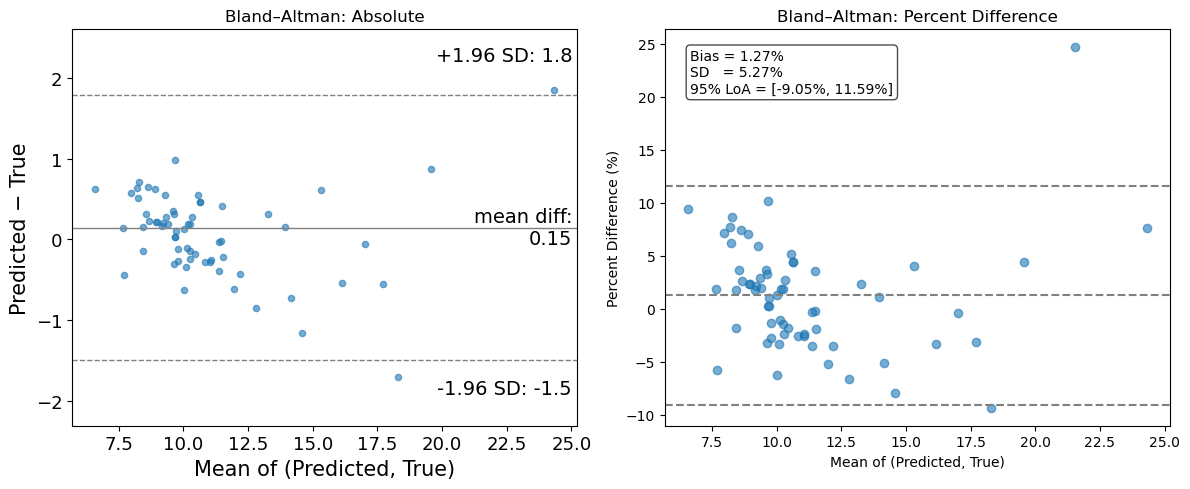

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [10]:
bland_altman_plots(test_sub, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


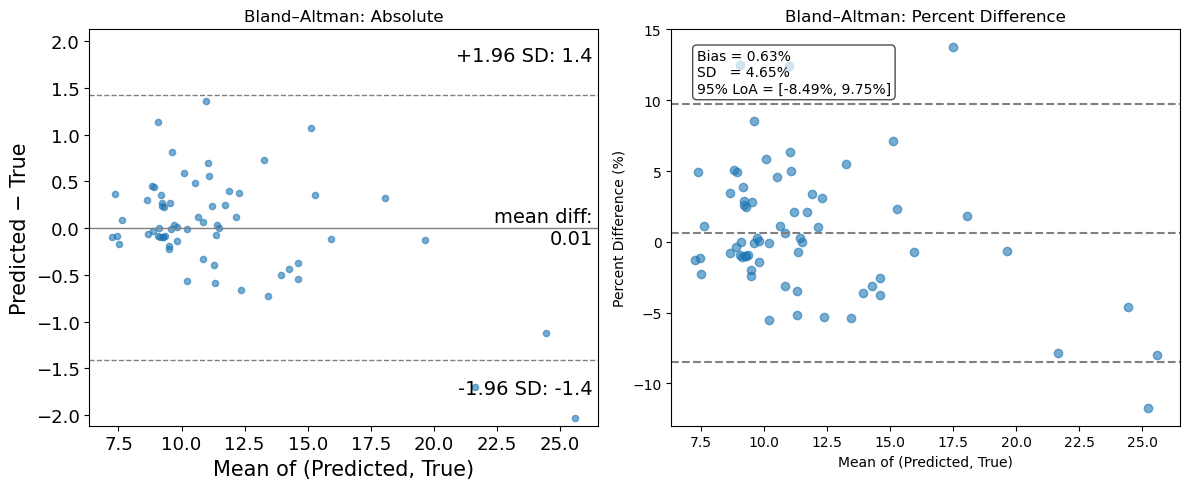

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [11]:
bland_altman_plots(val_sub, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')
